### Imports

In [1]:
import os
import glob
from collections import defaultdict
from multiprocessing.pool import Pool
import matplotlib.patches as mpatches

import numpy as np
import matplotlib
import re
import sys
import pickle as pkl

from matplotlib import pyplot as plt
from datetime import datetime
from cycler import cycler
import xarray as xr

sys.path.append('/home/ninow/master_thesis/code/project/')
from utils.data import DataUtils

### Define Constants

In [2]:
base_path = '/home/ninow/master_thesis/code/project/results/model_results/basic_results/'
output_path = base_path + '/plots'

### Load Data

In [3]:
# load 1NN results
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl', 'rb') as handle:
    experiment_statistic_1NN = pkl.load(handle)
    
# load 3NN results
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_3/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl', 'rb') as handle:
    experiment_statistic_3NN = pkl.load(handle)
    
# load grid size 3 results
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/grid_size_3/FC_L3_1024_256_64_TD_GTI_STI_grid_3_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl', 'rb') as handle:
    experiment_statistic_grid_size_3 = pkl.load(handle)
    
# load 1NN error prediction
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/error_label/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl', 'rb') as handle:
    experiment_statistic_1NN_error_prediction = pkl.load(handle)

In [13]:
print("Model test RMSE:", np.min(experiment_statistic_1NN_error_prediction.error_statistic.sel(run = 0, error = 'test')).item())
print("Model test RMSE:", np.min(experiment_statistic_1NN.error_statistic.sel(run = 0, error = 'test')).item())

Model test RMSE: 1.2687412554348299
Model test RMSE: 1.2868086604823532


In [ ]:
n_samples = experiment_statistic_1NN.samples_statistic[:,:,0] + experiment_statistic_1NN.samples_statistic[:,:,2]
n_used = experiment_statistic_1NN.samples_statistic[:,:,1] + experiment_statistic_1NN.samples_statistic[:,:,3]

In [8]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

### Generate Train/Test Plot with all runs for 1NN

#### Plot training results

In [129]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

model_names = ['Grid Size 1 (1NN)', '3NN', 'Grid Size 3']
error_statistics, epoch_results, best_results, run_times, samples_statistic = [], [], [], [], []
runs = 0
for ds_idx, ds in enumerate([experiment_statistic_1NN, experiment_statistic_3NN, experiment_statistic_grid_size_3]):

    if runs == 0:
        runs = ds.runs
        
    model_name = model_names[ds_idx]

    # get times for which prediction were made
    prediction_times = ds.error_statistic.prediction_times.data

    # get the mean of train and test error over all runs, additionally calculate the std. dev. to the mean
    # run_error_mean_std = tuple(mean, std), mean = ndarray(epoch, error), error = train or test error value,
    # lead = prediction for T = lead
    epoch_error_mean_std = (np.mean(ds.error_statistic.data, 0), np.std(ds.error_statistic.data, 0))
    # look up in train/test mean error per epoch, for which epoch the train resp. test error is the best and
    # return the index
    best_train_epoch, best_test_epoch = np.argmin(epoch_error_mean_std[0], 0)
    # advanced indexing: first select mean or variance. then define fore each prediction lead time the best epoch,
    # the error (train = 0 or test = 1) and the prediction lead time itself.
    # This reduces the [n_epoch, 2, n_future_predictions] -> [n__future_predictions
    best_error_mean_std_epoch = (epoch_error_mean_std[0][best_train_epoch, 0, range(len(prediction_times))],
                                 epoch_error_mean_std[1][best_train_epoch, 0, range(len(prediction_times))],
                                 best_train_epoch,
                                 epoch_error_mean_std[0][best_test_epoch, 1, range(len(prediction_times))],
                                 epoch_error_mean_std[1][best_test_epoch, 1, range(len(prediction_times))],
                                 best_test_epoch)

    # get min, max, mean, std time over all runs and epochs
    time_statistic = ds.run_time_statistic.data
    # first tuple element: name, second tuple element: data [axis 0: [min, max, mean, std], axis 1: epoch, train, test]
    run_times += [(model_name, np.array([np.min(time_statistic, axis=(0, 1)),
                                         np.max(time_statistic, axis=(0, 1)),
                                         np.mean(time_statistic, axis=(0, 1)),
                                         np.std(time_statistic, axis=(0, 1))]))]

    error_statistics += [(model_name, ds.error_statistic.data)]
    epoch_results += [(model_name, epoch_error_mean_std)]
    best_results += [(model_name, best_error_mean_std_epoch)]

    samples_statistic += [(model_name, np.mean(ds.samples_statistic.data, axis=(0, 1)))]

#### Plot test results

In [132]:
name, error_statistic = error_statistics[0]
    
# shape of error statistics: dim_0=Runs, dim_1=Epochs, dim_2=[train_err, test_err]
runs, epochs, *_ = error_statistic.shape

for prediction_time_idx, prediction_time in enumerate(prediction_times):

    current_output_path = output_path + '/prediction_T%s' % prediction_time
    if not os.path.exists(current_output_path):
        os.makedirs(current_output_path)

    x = [i + 1 for i in range(epochs)]

    fig, axes = plt.subplots(2, sharey=True, figsize=(15, 15))
    for run in range(runs):
        axes[0].plot(x, error_statistic[run, :, 0, prediction_time_idx], alpha=0.5, label='Run %s' % str(run + 1))
        axes[1].plot(x, error_statistic[run, :, 1, prediction_time_idx], alpha=0.5, label='Run %s' % str(run + 1))
    axes[0].plot(x, np.mean(error_statistic[:, :, 0, prediction_time_idx], axis=0), 'r--', label='Mean')
    axes[1].plot(x, np.mean(error_statistic[:, :, 1, prediction_time_idx], axis=0), 'r--', label='Mean')

    axes[1].set_xlabel('Epoch', fontsize=16)

    axes[0].set_title('Train Error', fontsize=16)
    axes[1].set_title('Test Error', fontsize=16)
    for i in range(2):
        axes[i].set_xticks(x)
        axes[i].set_ylabel('RMSE [°C]', fontsize=16)
        axes[i].grid(True)
        axes[i].legend()

    axes[0].text(0.05, 0.1,
                 'Min. Mean Error: %s' % "{:2.3f}".format(
                     np.min(np.mean(error_statistic[:, :, 0, prediction_time_idx], axis=0))),
                 fontsize=18, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.05, 0.1,
                 'Min. Mean Error: %s' % "{:2.3f}".format(
                     np.min(np.mean(error_statistic[:, :, 1, prediction_time_idx], axis=0))),
                 fontsize=18, fontweight='bold', transform=axes[1].transAxes)
    axes[0].text(0.05, 0.05,
                 'Min. Error: %s' % "{:2.3f}".format(np.min(error_statistic[:, :, 0, prediction_time_idx])),
                 fontsize=18,
                 transform=axes[0].transAxes)
    axes[1].text(0.05, 0.05,
                 'Min. Error: %s' % "{:2.3f}".format(np.min(error_statistic[:, :, 1, prediction_time_idx])),
                 fontsize=18,
                 transform=axes[1].transAxes)

    plt.ylim(0, 1.2 * np.max(error_statistic[:, :, 0, prediction_time_idx]))
    plt.suptitle(str(" ".join(name.split("_")) + " (Lead Prediction = %s)" % prediction_time), fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96], h_pad=4)
    fig.savefig(output_path + '/grid_size_1_train_test_error_plot.png')
    plt.close()

### Generate Bar Plot wiht 1NN, 3NN and Grid Size 3

### Prepare results of nerual networks to be plotted

In [71]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

model_names = ['Grid Size 1 (1NN)', '3NN', 'Grid Size 3']
error_statistics, epoch_results, best_results, run_times, samples_statistic = [], [], [], [], []
runs = [0,1,2]
for ds_idx, ds in enumerate([experiment_statistic_1NN, experiment_statistic_3NN, experiment_statistic_grid_size_3]):

    # only use first three runs to be comparable to baselines
    ds = ds.sel(run = runs)
    
    model_name = model_names[ds_idx]

    # get times for which prediction were made
    prediction_times = ds.error_statistic.prediction_times.data

    # get the mean of train and test error over all runs, additionally calculate the std. dev. to the mean
    # run_error_mean_std = tuple(mean, std), mean = ndarray(epoch, error), error = train or test error value,
    # lead = prediction for T = lead
    epoch_error_mean_std = (np.mean(ds.error_statistic.data, 0), np.std(ds.error_statistic.data, 0))
    # look up in train/test mean error per epoch, for which epoch the train resp. test error is the best and
    # return the index
    best_train_epoch, best_test_epoch = np.argmin(epoch_error_mean_std[0], 0)
    # advanced indexing: first select mean or variance. then define fore each prediction lead time the best epoch,
    # the error (train = 0 or test = 1) and the prediction lead time itself.
    # This reduces the [n_epoch, 2, n_future_predictions] -> [n__future_predictions
    best_error_mean_std_epoch = (epoch_error_mean_std[0][best_train_epoch, 0, range(len(prediction_times))],
                                 epoch_error_mean_std[1][best_train_epoch, 0, range(len(prediction_times))],
                                 best_train_epoch,
                                 epoch_error_mean_std[0][best_test_epoch, 1, range(len(prediction_times))],
                                 epoch_error_mean_std[1][best_test_epoch, 1, range(len(prediction_times))],
                                 best_test_epoch)

    # get min, max, mean, std time over all runs and epochs
    time_statistic = ds.run_time_statistic.data
    # first tuple element: name, second tuple element: data [axis 0: [min, max, mean, std], axis 1: epoch, train, test]
    run_times += [(model_name, np.array([np.min(time_statistic, axis=(0, 1)),
                                         np.max(time_statistic, axis=(0, 1)),
                                         np.mean(time_statistic, axis=(0, 1)),
                                         np.std(time_statistic, axis=(0, 1))]))]

    error_statistics += [(model_name, ds.error_statistic.data)]
    epoch_results += [(model_name, epoch_error_mean_std)]
    best_results += [(model_name, best_error_mean_std_epoch)]

    samples_statistic += [(model_name, np.mean(ds.samples_statistic.data, axis=(0, 1)))]

### Plot results for neural network models as bar plot

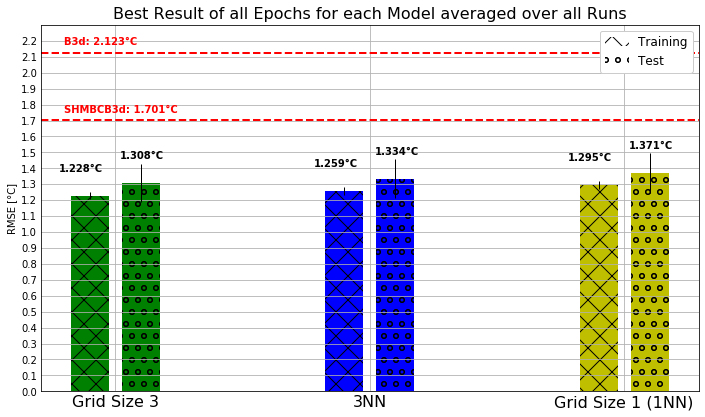

In [72]:
# create path if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

colors = ['g', 'b', 'y', 'c', 'm', 'k']

model_names = ['Grid Size 3', '3NN', 'Grid Size 1 (1NN)']

# plot train error
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

for prediction_time_idx, prediction_time in enumerate(prediction_times):

    current_output_path = output_path + '/prediction_T%s' % prediction_time
    if not os.path.exists(current_output_path):
        os.makedirs(current_output_path)

    # plot test error
    best_test_results = sorted(best_results, key=lambda x: x[1][3][prediction_time_idx])
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, result in enumerate(best_test_results):
        mean_train = result[1][0]
        std_train = result[1][1]
        mean_test = result[1][3]
        std_test = result[1][4]
        
        # plot train rmse bar
        ax.bar(x=idx, height=mean_train, width=0.15, yerr=std_train, label=result[0],
               color=colors[idx % len(colors)], hatch='x')
        ax.text(idx - 0.12, mean_train + .15, "%.3f°C" % mean_train, fontweight='bold')
        
        # plot test rmse bar
        ax.bar(x=idx + 0.2, height=mean_test, width=0.15, yerr=std_test,
               color=colors[idx % len(colors)], hatch='o')
        ax.text(idx + 0.12, mean_test + .15, "%.3f°C" % mean_test, fontweight='bold')
        
    # plot baseline results
    b3d_best_3_runs = 2.123
    plt.axhline(y=b3d_best_3_runs, color='r', linewidth=2, linestyle='--')
    ax.text(-0.1, b3d_best_3_runs + .05, "B3d: %.3f°C" % b3d_best_3_runs, color='r', fontweight='bold')
    shmbcb3d_best_3_runs = 1.701
    plt.axhline(y=shmbcb3d_best_3_runs, color='r', linewidth=2, linestyle='--')
    ax.text(-0.1, shmbcb3d_best_3_runs + .05, "SHMBCB3d: %.3f°C" % shmbcb3d_best_3_runs, color='r', fontweight='bold')
    
    ax.set_xticks([])
    plt.ylim(0,2.3)
    plt.yticks(np.arange(0,2.3,0.1))
    plt.ylabel('RMSE [°C]')
    plt.grid()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.title('Best Result of all Epochs for each Model averaged over all Runs', fontsize=16)
    
    # describe model as xticks
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.xticks(np.arange(3) + 0.1, model_names, fontsize=16)
    
    # create legend to distinguish training and test
    circ1 = mpatches.Patch(facecolor='white', hatch='x', label='Training')
    circ2= mpatches.Patch(facecolor='white', hatch='o', label='Test')
    ax.legend(handles=[circ1, circ2], loc='best', fancybox=True, framealpha=1, prop={'size':12})

    fig.savefig(current_output_path + '/best_result_by_test_error.png')
    
    plt.show()
    
    plt.close()

### Plots of forecast skill (FS) on the map of Switzerland <br>
THIS CODE IS IN THE PLOT BASELINE RESULTS NOTEBOOK!

# Backup (not used)

## Select Points for Feature Interpretability and Data Valuation

In [4]:
# load 1NN results
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl', 'rb') as handle:
    experiment_statistic_1NN = pkl.load(handle)
    
# load prediction run data
# load 1NN results
with open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb') as handle:
    prediction_run_1NN = pkl.load(handle)

In [35]:
all_test_inits = [idx for idx, i in enumerate(prediction_run_1NN.run_0.init_type_mapping) if i[1] == 'test']
test_predictions = prediction_run_1NN.run_0[all_test_inits]
run0_prediction = test_predictions.sel(data = 'prediction', )
run0_cosmo = test_predictions.sel(data = 'cosmo')
run0_target = test_predictions.sel(data = 'target')
run0_difference = test_predictions.sel(data = 'difference')

#### Best Forecast Skill single point

In [36]:
absolute_error_prediction = np.absolute(run0_prediction-run0_target)
absolute_error_cosmo = np.absolute(run0_cosmo-run0_target)

forecast_skill = 1-(absolute_error_prediction/absolute_error_cosmo)
best_forecast_skill_idx = np.unravel_index(np.argmax(forecast_skill).item(), forecast_skill.shape)
best_forecast_skill = forecast_skill[best_forecast_skill_idx]
best_init = best_forecast_skill.init.item()
best_station = best_forecast_skill.station.item()
print("Best Init.: %s.%s.20%s %s:00, Station: %s, Forecast Skill = %.2f%%" % (best_init[4:6],
                                                                              best_init[2:4],
                                                                              best_init[:2],
                                                                              best_init[6:8],
                                                                              station_names[station_idx_mapping[best_station]].item(),
                                                                              100*best_forecast_skill))

Best Init.: 13.08.2016 09:00, Station: Vaduz, Forecast Skill = 100.00%


In [38]:
absolute_error_prediction[best_forecast_skill_idx], absolute_error_cosmo[best_forecast_skill_idx]

(<xarray.DataArray 'run_0' ()>
 array(2.479553e-05)
 Coordinates:
     init     <U8 '16081309'
     station  int32 36, <xarray.DataArray 'run_0' ()>
 array(1.225244)
 Coordinates:
     init     <U8 '16081309'
     station  int32 36)

In [39]:
best_forecast_skill_idx

(330, 30)

#### Best Forecast Skill over inits

In [8]:
rmse_error_prediction = np.sqrt(np.nanmean(np.square(run0_prediction-run0_target), axis=1))
rmse_error_cosmo = np.sqrt(np.nanmean(np.square(run0_cosmo-run0_target), axis=1))

forecast_skill = 1-(rmse_error_prediction/rmse_error_cosmo)
best_forecast_skill = np.argmax(forecast_skill).item()
best_init = run0_prediction[best_forecast_skill].init.item()
print("Best Init.: %s.%s.20%s %s:00, Forecast Skill = %.2f%%" % (best_init[4:6],
                                                              best_init[2:4],
                                                              best_init[:2],
                                                              best_init[6:8],
                                                              100*forecast_skill[best_forecast_skill]))

Best Init.: 18.03.2016 12:00, Forecast Skill = 72.78%


#### Best Forecast Skill over stations

In [41]:
rmse_error_prediction = np.sqrt(np.nanmean(np.square(run0_prediction-run0_target), axis=0))
rmse_error_cosmo = np.sqrt(np.nanmean(np.square(run0_cosmo-run0_target), axis=0))

forecast_skill = 1-(rmse_error_prediction/rmse_error_cosmo)
best_forecast_skill = np.argmax(forecast_skill).item()
best_station = run0_prediction[:,best_forecast_skill].station.item()
print("Best Station: %s (Id: %s, Idx: %s), Forecast Skill = %.2f%%" % (station_names[station_idx_mapping[best_station]].item(), best_station, station_idx_mapping[best_station],100*forecast_skill[best_forecast_skill]))

Best Station: Grimsel Hospiz (Id: 91, Idx: 83), Forecast Skill = 68.91%


In [47]:
best_10_station_indices = np.argsort(forecast_skill)[-10:]

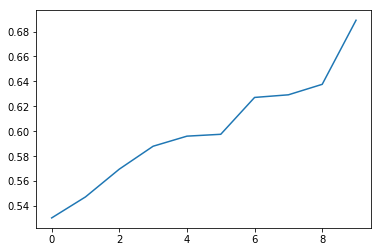

In [49]:
plt.plot(forecast_skill[best_10_station_indices])
plt.show()

In [64]:
forecast_skill[best_10_station_indices]

array([0.53048063, 0.54733404, 0.56961765, 0.58799973, 0.59608193,
       0.59757883, 0.62714642, 0.62925599, 0.63766753, 0.68908702])

In [56]:
np.mean(absolute_error_prediction.isel(station = best_10_station_indices),axis=0)

<xarray.DataArray 'run_0' (station: 10)>
array([0.998276, 0.860639, 1.00075 , 0.862908, 1.11308 , 0.974134, 0.726002,
       0.794659, 0.910693, 0.793069])
Coordinates:
  * station  (station) int32 37 521 1024 23 317 131 35 273 96 91

In [65]:
np.mean(absolute_error_cosmo.isel(station = best_10_station_indices),axis=0)

<xarray.DataArray 'run_0' (station: 10)>
array([2.173926, 2.049918, 2.252582, 2.333005, 2.92031 , 2.509511, 2.293948,
       2.418144, 2.758394, 2.947147])
Coordinates:
  * station  (station) int32 37 521 1024 23 317 131 35 273 96 91

In [66]:
1-(0.726/2.2939)

0.6835084354156676

In [57]:
station_names[best_10_station_indices]

<xarray.DataArray 'station_name' (station: 10)>
array(['Aigle', 'Col des Mosses', 'Schiers', 'Passo del Bernina', 'Mottec',
       'Binn', 'Säntis', 'Titlis', 'Robièi', 'Grimsel Hospiz'], dtype='<U24')
Coordinates:
  * station  (station) int32 37 521 1024 23 317 131 35 273 96 91

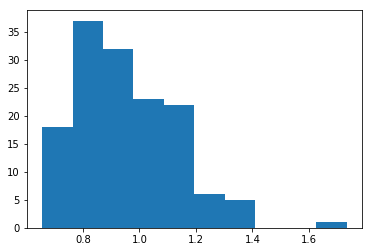

In [60]:
plt.hist(np.mean(absolute_error_prediction, axis=0),10)
plt.show()